# Load libraries

In [1]:
from PIL import Image
import numpy as np
import os
import pickle
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm

from scipy.spatial.distance import cdist,pdist, squareform
from scipy import stats

from skimage.transform import resize
from skimage.transform import downscale_local_mean

D:\zsh\graduation\grad_env_take_2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [2]:
# path of the image folders for the model
image_path_cityscapes = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\original_cityscapes_inputs"
# 500 images
image_path_synthia = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\SYNTHIA_256\image"
# 9400 images

# path of image folders for displaying in the system
start = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image"
relative_img_path_cityscapes = os.path.relpath(image_path_cityscapes, start)
relative_img_path_synthia = os.path.relpath(image_path_synthia, start)

In [3]:
# load label files for for cityscapes images
pickle_file = os.path.join("D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\\5_classes_preprocessed", "validation_label_classes.pkl")
with open(pickle_file, 'rb') as f:
    Y_test = pickle.load(f)
    
cityscapes_labels = np.array(Y_test)

In [4]:
# sample size, for the system it's 500 by default
sample_number = 50

In [5]:
cityscapes_names= os.listdir(image_path_cityscapes)
random.seed(55)
cityscapes_names_sample = random.sample(cityscapes_names,sample_number)

In [6]:
cityscapes_names_sample

['14.jpeg',
 '87.jpeg',
 '189.jpeg',
 '167.jpeg',
 '439.jpeg',
 '237.jpeg',
 '486.jpeg',
 '134.jpeg',
 '442.jpeg',
 '183.jpeg',
 '139.jpeg',
 '260.jpeg',
 '70.jpeg',
 '430.jpeg',
 '74.jpeg',
 '94.jpeg',
 '498.jpeg',
 '403.jpeg',
 '315.jpeg',
 '347.jpeg',
 '276.jpeg',
 '277.jpeg',
 '33.jpeg',
 '285.jpeg',
 '244.jpeg',
 '43.jpeg',
 '88.jpeg',
 '296.jpeg',
 '344.jpeg',
 '454.jpeg',
 '39.jpeg',
 '116.jpeg',
 '216.jpeg',
 '117.jpeg',
 '9.jpeg',
 '204.jpeg',
 '334.jpeg',
 '423.jpeg',
 '104.jpeg',
 '361.jpeg',
 '311.jpeg',
 '485.jpeg',
 '200.jpeg',
 '121.jpeg',
 '272.jpeg',
 '395.jpeg',
 '188.jpeg',
 '202.jpeg',
 '450.jpeg',
 '193.jpeg']

In [7]:
cityscapes_labels_sample= []
cityscapes_label_path_sample = []

for name in cityscapes_names_sample:
    ind = int(name.split('.')[0]) # todo: change this for other names
    label = cityscapes_labels[ind]
    
    cityscapes_labels_sample.append(label)

cityscapes_labels_sample = np.array(cityscapes_labels_sample)



## Create dataloader

Cityscapes

In [8]:
class CityscapesDataset(Dataset):
    
    def __init__(self, images, labels, noise_level = 0):
        self.images = images
        self.labels = labels
        self.noise_level = noise_level
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        if self.noise_level!=0:
            image = image+(self.noise_level*np.random.normal(0, (image.max() - image.min()), image.shape)).astype("uint8") # (mean, sigma, image_shape)
        image = self.transform(image)
        label = torch.from_numpy(label).long()
        return image, label
        
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) # normalize to control the "dynamic range" of activations of different layers
        ])
        return transform_ops(image)

In [9]:
# all the images for cityscapes
cityscapes_images= []
for name in cityscapes_names_sample:
    image = Image.open(image_path_cityscapes+"\\"+name).convert("RGB")
    cityscapes_images.append(image)

In [10]:
batch_size = 1
cityscapes_dataset = CityscapesDataset(cityscapes_images, cityscapes_labels,noise_level=0)
cityscapes_loader = DataLoader(cityscapes_dataset, batch_size=batch_size)

In [11]:
len(cityscapes_loader)

50

# Load the model

In [12]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out, middle_out

In [13]:
model_path = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\models\\5-classes-U-Net-2023-03-09.pth"
device = torch.device('cpu')
model_ = UNet(num_classes=6).to(device)
model_.load_state_dict(torch.load(model_path,map_location=device))

<All keys matched successfully>

output size [1,6,256,256]

activations size[1,1024,16,16]

In [14]:
# change the activations first
cityscapes_activations = []
cityscapes_output_classes = []

for image,label in tqdm(cityscapes_loader):
    output,bottleneck_activations = model_(image)
    output_class=torch.argmax(output, dim=1).detach().numpy()[0]
    instance_activation_reshaped = bottleneck_activations.clone().detach().numpy().squeeze(0).reshape(1024,256).transpose()
    cityscapes_activations.append(instance_activation_reshaped)
    cityscapes_output_classes.append(output_class)
    

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


In [15]:
cityscapes_activations = np.array(cityscapes_activations)#(sample_num,256,1024)
cityscapes_output_classes = np.array(cityscapes_output_classes) #(sample_num,256,256)

In [16]:
# find the min and max value of this 3d array
print("Min Value: ", np.min(cityscapes_activations))
print("2% percentile:",np.percentile(cityscapes_activations, 2))
print("Median value:",np.percentile(cityscapes_activations, 50))
print("98% percentile:",np.percentile(cityscapes_activations, 98))
print("Max Value: ", np.max(cityscapes_activations))


Min Value:  -21.021082
2% percentile: -0.5420851111412048
Median value: -0.1018519401550293
98% percentile: 2.8671432399749524
Max Value:  117.311035


Idea: need to do clipping  (leave it now for comparison purposes)

# Distance heatmap
1. select a sample activation image
2. map class to the activation image
3. re-arrange the pixels so that different classes are together
4. calculate the distance between pixels
5. distance matrix to heatmap

First do minmax scaling to scale all of the 1024 features to (0,1)

In [17]:
# select the first image of the subset (which corresponds to image 14 in the dataset)
selected_index = 0
sample_activation_image = cityscapes_activations[selected_index]

scaler = MinMaxScaler()
scaler.fit(sample_activation_image)
sample_activation_image = scaler.transform(sample_activation_image)

# load the labels
label = cityscapes_labels_sample[selected_index]

# load the class names
class_names = ["others","road","sidewalk","vegetation","sky","car"]

In [18]:
# Reshape to 16x16 blocks
reshaped = label.reshape((16, 16, 16, 16))

# # Find the most common label within each block
# Initialize an array to hold the output
downscaled = np.empty((16, 16), dtype=label.dtype)

# Loop over each block and compute the mode
for i in range(16):
    for j in range(16):
        block = reshaped[i, :, j, :].flatten()  # Flatten the block
        downscaled[i, j] = stats.mode(block).mode[0]

print(downscaled)  # Should print: (16, 16)
# checked the corresponding image ("14.jpeg") and this downscaled mask match with the original mask

[[4 3 3 3 3 3 3 3 3 0 4 0 0 3 3 0]
 [3 3 3 4 3 3 3 3 3 3 4 0 0 3 3 0]
 [0 3 4 4 3 3 3 3 3 3 4 0 0 3 3 0]
 [3 3 3 3 3 3 3 3 3 3 3 0 0 3 3 0]
 [3 3 3 3 3 3 3 3 3 3 3 0 0 3 0 0]
 [3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0]
 [3 3 3 3 0 0 0 5 5 5 0 0 0 0 0 0]
 [0 0 1 1 0 0 1 1 1 1 2 2 2 2 2 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2]
 [1 1 1 1 1 1 1 1 1 0 1 1 1 1 2 2]
 [1 1 1 1 1 1 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [19]:
sample_activations = sample_activation_image.copy() # to make sure not to overwrite the sample_activation_image variable

In [20]:
# count the number of unique values for each features
unique_count = []
unique_values = []
for i in range(len(sample_activations[0])):
    sub_unique_values = np.unique(sample_activations[:,i])
    sub_unique_count = len(sub_unique_values)
    unique_count.append(sub_unique_count)
    unique_values.append(sub_unique_values)

<AxesSubplot:ylabel='Count'>

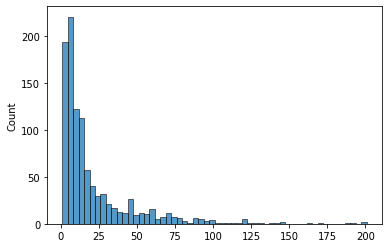

In [21]:
# histograms of unique values per feature, many features only have few values
sns.histplot(unique_count)

<AxesSubplot:ylabel='Count'>

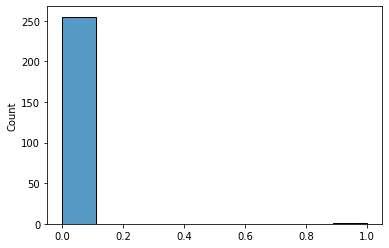

In [22]:
# for the first feature, there are only two values
sns.histplot(sample_activation_image[:,0]) 

In [23]:


# Flatten the class mask
flattened_classes = downscaled.flatten() # downscaled is the pseudo mask for activations

# Get the sorting indices
sorting_indices = np.argsort(flattened_classes)
sorted_classes = np.sort(flattened_classes)

# Use the indices to sort the pixels and the distance matrix
sorted_activations = sample_activations[sorting_indices]

# Compute the pairwise distance matrix
distances = pdist(sorted_activations)

# Convert to square form
distance_matrix = squareform(distances)

print(distance_matrix.shape)  # Should print: (256, 256)
        

(256, 256)


In [24]:
# make the axis for the heatmap with the class name of each pixel. Note that the pixels from the same classes are grouped together
    # and for simplicity we only show the class name for the first row/column that corresponds to a class, and skip the other names
sorted_classes_names = []
for item in sorted_classes:
    name = class_names[item]
    if name not in sorted_classes_names:
        sorted_classes_names.append(class_names[item])
    else:
        sorted_classes_names.append("")

In [25]:
# verify the sorting
print((sample_activations[sorting_indices[0]]==sorted_activations[0]).all())

True


In [26]:
print(np.mean(distance_matrix))
print(np.min(distance_matrix))
print(np.max(distance_matrix))

5.051787329498169
0.0
11.067221806216056


In [27]:
# reorder the distances (corresponding to vectors) within classes so that the ones with lowest distance within the same class is always on the front
def reorder_distance_matrix(distance_matrix, labels):
    unique_labels = list(set(labels))
    avg_distances = []
    # for each labels, find the average distances of it to other classes
    for i, label in enumerate(labels):
        same_class_indices = np.where(labels == label)[0]
        avg_distance = np.mean(distance_matrix[i, same_class_indices])
        avg_distances.append(avg_distance)

    # Now, sort indices within each class by their average distance
    sorted_indices = []
    for label in unique_labels:
        label_indices = [i for i, l in enumerate(labels) if l == label]
        label_indices_sorted = sorted(label_indices, key=lambda x: avg_distances[x])
        sorted_indices.extend(label_indices_sorted)
    
    # Reorder the distance matrix based on the sorted indices
    reordered_matrix = distance_matrix[sorted_indices, :][:, sorted_indices]
    
    return reordered_matrix

In [28]:
reordered_matrix = reorder_distance_matrix(distance_matrix, sorted_classes)

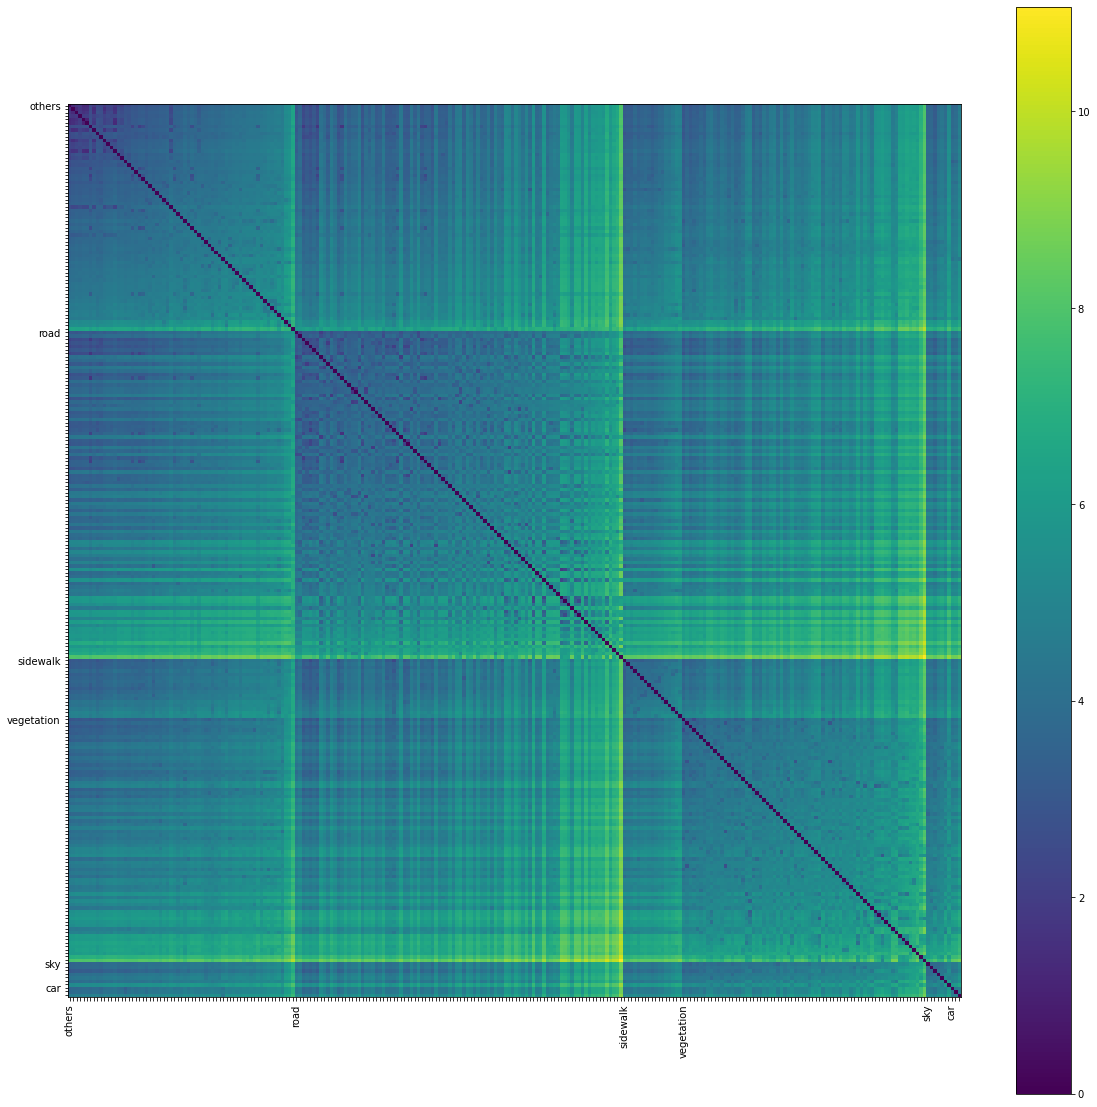

In [29]:
# plot the distance heatmap - still does not look good
plt.figure(figsize=(20,20))
plt.imshow(reordered_matrix)

plt.xticks(range(len(sorted_classes_names)), sorted_classes_names, rotation=90)  # rotation might be useful for better clarity
plt.yticks(range(len(sorted_classes_names)), sorted_classes_names)

plt.colorbar()
plt.show()

## Generate and check activations
Goal: first calculate the t-SNE using all images; then for the first image, plot the t-SNE results, which marks the pixel points from different classes in different colors

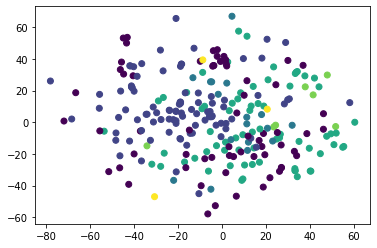

In [30]:
# tsne plots
activations_concatenated = np.reshape(cityscapes_activations,(sample_number*256,1024)) # 256 is 16x16, the activation "image"
activations_tsne_embedding = TSNE(n_components=2).fit_transform(activations_concatenated)
activations_tsne_embedding_reshaped = np.reshape(activations_tsne_embedding,(sample_number,256,2))
plt.scatter(activations_tsne_embedding_reshaped[0,:,0],activations_tsne_embedding_reshaped[0,:,1],c=flattened_classes)

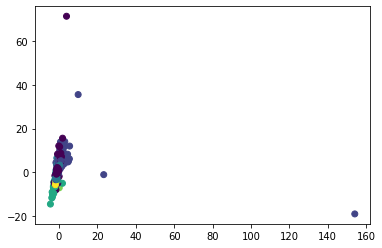

In [31]:
# pca plots
activations_pca_embedding = PCA(n_components=2).fit_transform(activations_concatenated)
activations_pca_embedding_reshaped = np.reshape(activations_pca_embedding,(sample_number,256,2))
plt.scatter(activations_pca_embedding_reshaped[0,:,0],activations_pca_embedding_reshaped[0,:,1],c=flattened_classes)